In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
# Various time series models within booster models
from timeseries_models import * 

In [3]:
# Read in data and filter to time frame
file_name = ""
df_load = dataiku.Dataset(file_name).get_dataframe()
df= df_load.copy()

### 1. Scope

In [4]:
# Call data scope function
df = prediction_scope(df_load, '1995-03-31', '2019-06-30')

In [5]:
# GRIDSEARCH INPUTS
target_i = "sales"
event_i = 'event_date'
select_cols = [c for c in df.columns]
train_i = 0.7
num_periods_i = 4
freq_i = 'Q'

### 2. LGB

In [6]:
lgbm_params_dict = {
    'num_leaves': [31],
    'max_depth' : [-1],
    'learning_rate': [0.06, 0.1],
    'min_child_samples': [5, 10, 22,23]}

lg_results = lgbm_gridsearch(df, lgbm_params_dict, target_i, num_periods_i, freq_i, event_i, select_cols, train_i, verbose=False)

# Call grid_best_model function
lg_best_score, lg_best_models = grid_best_model(lg_results, 'lgb')

best_score:  46443.687376156835
{'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.06, 'min_child_samples': 23}


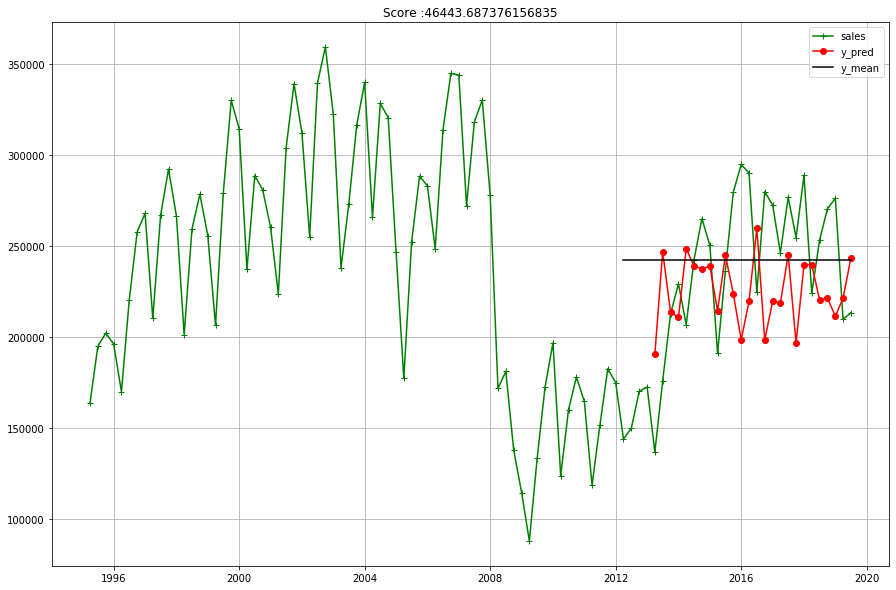

In [7]:
# Plot results of best model for past and future
lg_best_models[0].plot(title = f"Score :{lg_best_models[0].score}")

### 3. XGBoost

In [8]:
xgb_params = {
    'eta': [0.21],
    'max_depth': [9],
    'min_child_weight': [1],
    'subsample': [0.595],
    'lambda': [0.7],   
    'alpha': [0.75]
}
xgb_static_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
#     'verbosity': 1
}

xg_results = xgb_gridsearch(df, xgb_params, xgb_static_params, target_i, num_periods_i, freq_i, event_i, 
                         select_cols, train_i, nbr=250, verbose=False)

# Call grid_best_model function
xg_best_score, xg_best_models = grid_best_model(xg_results, 'xg')

best_score:  44973.53900689709
{'eta': 0.21, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.595, 'lambda': 0.7, 'alpha': 0.75, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}


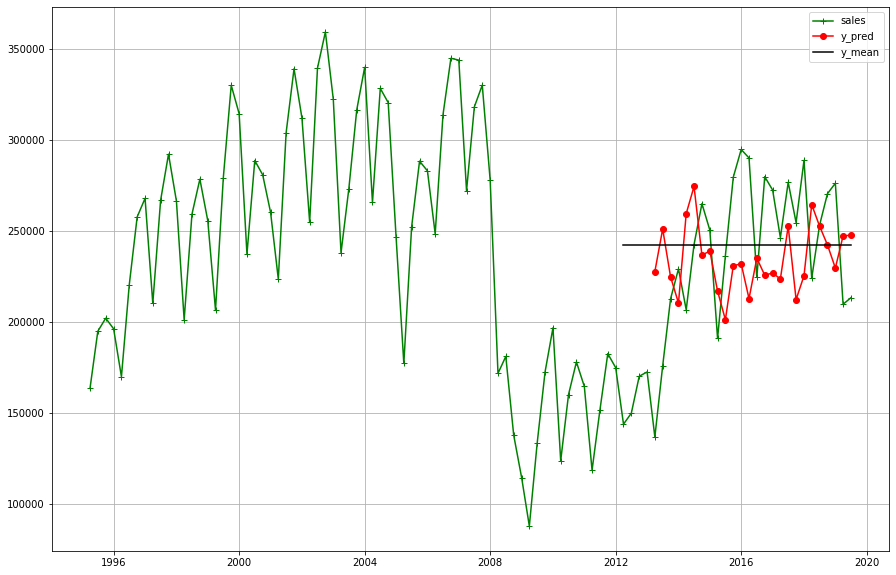

In [9]:
xg_best_models[0].plot()

### 4. COMBINED XGBoost and LGBM

In [10]:
def MAE(y, ypred):
    return np.sum([abs(y[i]-ypred[i]) for i in range(len(y))]) / len(y)

In [ ]:
for x in linspace(0, 1, 10):

In [73]:
y_actual = xg_best_models[0].df_in[target_i]
y_name = xg_best_models[0].target
y_mean = xg_best_models[0].results.y_mean
xg_y_pred = xg_best_models[0].results.y_pred.rename("xg_y_pred")
lg_y_pred = lg_best_models[0].results.y_pred.rename("lg_y_pred")

# Set weight parameters and series
mae = {}
for i in linspace(0, 1, 10):
    xg_weight = i
    lgb_weight = 1 - xg_weight
    combined_y_pred = ((xg_y_pred * xg_weight) + (lg_y_pred * lgb_weight)).rename("combined_y_pred")
    all_model_df = pd.concat([y_actual, y_mean, xg_y_pred, lg_y_pred, combined_y_pred], axis=1)
    mae = MAE(all_model_df.dropna()[y_name], all_model_df.dropna().combined_y_pred)

In [85]:
# XGBoost error
print("XGBoost MAE: ", MAE(all_model_df.dropna()[y_name], all_model_df.dropna().xg_y_pred))

# LGB error
print("LGB MAE: ", MAE(all_model_df.dropna()[y_name], all_model_df.dropna().lg_y_pred))

# Combined error
print("Combined Model MAE: ", MAE(all_model_df.dropna()[y_name], all_model_df.dropna().combined_y_pred))

XGBoost MAE:  39298.40504807692
LGB MAE:  39339.40202038475
Combined Model MAE:  38855.50706850596


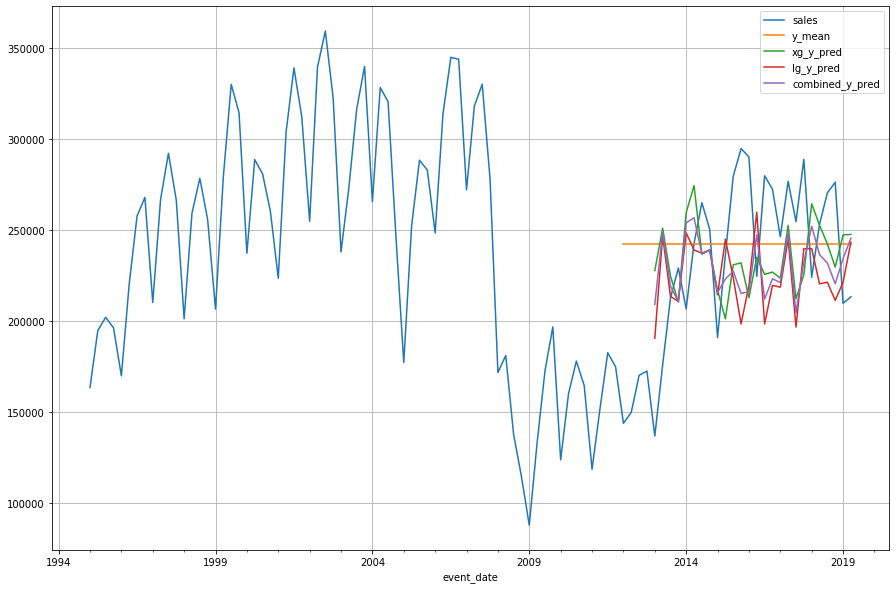

In [86]:
all_model_df.plot(grid=True, figsize=(15,10))